# Classification of Thyroid Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#helper functions

In [2]:
def parse_row(row):
    row = row.split(".")[0]
    return row

def to_hyperthyroid(row):
    if row != "negative":
        row = "hyperthyroid"
    return row

def to_hypothyroid(row):
    if row != "negative":
        row = "hypothyroid"
    return row

def convert_category(dataframe, column):
    
    if column == 'Sex':
        conditionF = dataframe[column] == 'F' # For sex column
        conditionT = dataframe[column] == 'M' # For sex column
    else:
        conditionF = dataframe[column] == 'f'
        conditionT = dataframe[column] == 't'
    
    dataframe.loc[conditionF, column] = 0
    dataframe.loc[conditionT, column] = 1

# Data Retrival

In [3]:
columns = ["Age", "Sex", "On Thyroxine", "Query on Thyroxine", 
           "On Antithyroid Medication", "Sick", "Pregnant", 
           "Thyroid Surgery", "I131 Treatment", "Query Hypothyroid", 
           "Query Hyperthyroid", "Lithium", "Goitre", "Tumor", 
           "Hypopituitary", "Psych", "TSH Measured", "TSH", "T3 Measured", 
           "T3", "TT4 Measured", "TT4", "T4U Measured", "T4U", 
           "FTI Measured", "FTI", "TBG Measured", "TBG", "Referral Source", "Category"]

In [4]:
hyper_data = pd.read_csv("hypothyroid.csv", names=columns)
hypo_data = pd.read_csv("hypothyroid.csv", names=columns)
sick_data = pd.read_csv("hypothyroid.csv", names=columns)

In [7]:
hyper_data.shape

(3773, 30)

In [5]:
hyper_data['Category'] = hyper_data['Category'].apply(parse_row).apply(to_hyperthyroid)

hypo_data['Category'] = hypo_data['Category'].apply(parse_row).apply(to_hypothyroid)

sick_data['Category'] = sick_data['Category'].apply(parse_row)

In [14]:
# Combined Thyroid Data

thyroid_frames = [hyper_data, hypo_data, sick_data]
thyroid_data = pd.concat(thyroid_frames).drop_duplicates().drop(['Referral Source', 'TBG', 'TBG Measured'], axis=1)

In [16]:
classes = thyroid_data['Category'].unique()
classes

array(['hyperthyroid', 'hypothyroid', 'binaryClass', 'P', 'N'],
      dtype=object)

In [17]:
print("Number of samples:", len(thyroid_data))

Number of samples: 11136


In [18]:
thyroid_data.head()

,Age,Sex,On Thyroxine,Query on Thyroxine,On Antithyroid Medication,Sick,Pregnant,Thyroid Surgery,I131 Treatment,Query Hypothyroid,...,TSH,T3 Measured,T3,TT4 Measured,TT4,T4U Measured,T4U,FTI Measured,FTI,Category
0,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,hyperthyroid
1,41,F,f,f,f,f,f,f,f,f,...,1.3,t,2.5,t,125,t,1.14,t,109,hyperthyroid
2,23,F,f,f,f,f,f,f,f,f,...,4.1,t,2,t,102,f,?,f,?,hyperthyroid
3,46,M,f,f,f,f,f,f,f,f,...,0.98,f,?,t,109,t,0.91,t,120,hyperthyroid
4,70,F,t,f,f,f,f,f,f,f,...,0.16,t,1.9,t,175,f,?,f,?,hyperthyroid


# Data Cleaning

In [19]:
# A quick fix needed
#thyroid_data.loc[thyroid_data['Age'] == '455', 'Age'] = '45'

In [25]:
# Binarize Category Columns
binary_cols = ['On Thyroxine', 'Query on Thyroxine', 'Sex',
               'On Antithyroid Medication', 'Sick', 'Pregnant', 
               'Thyroid Surgery', 'I131 Treatment', 'Query Hypothyroid', 
               'Query Hyperthyroid', 'Lithium', 'Goitre', 'Tumor', 
               'Hypopituitary', 'Psych', 'TSH Measured', 'T3 Measured', 
               'TT4 Measured', 'T4U Measured', 'FTI Measured']

for col in binary_cols: convert_category(thyroid_data, col)

In [42]:
thyroid_data=thyroid_data.drop(0)

,Age,Sex,On Thyroxine,Query on Thyroxine,On Antithyroid Medication,Sick,Pregnant,Thyroid Surgery,I131 Treatment,Query Hypothyroid,...,TSH,T3 Measured,T3,TT4 Measured,TT4,T4U Measured,T4U,FTI Measured,FTI,Category
1,41.0,0,0,0,0,0,0,0,0,0,...,1.3,1,2.5,1,125,1,1.14,1,109,hyperthyroid
2,23.0,0,0,0,0,0,0,0,0,0,...,4.1,1,2,1,102,0,NaN,0,NaN,hyperthyroid
3,46.0,1,0,0,0,0,0,0,0,0,...,0.98,0,NaN,1,109,1,0.91,1,120,hyperthyroid
4,70.0,0,1,0,0,0,0,0,0,0,...,0.16,1,1.9,1,175,0,NaN,0,NaN,hyperthyroid
5,70.0,0,0,0,0,0,0,0,0,0,...,0.72,1,1.2,1,61,1,0.87,1,70,hyperthyroid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,30.0,0,0,0,0,0,0,0,0,0,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,P
3769,68.0,0,0,0,0,0,0,0,0,0,...,1,1,2.1,1,124,1,1.08,1,114,P
3770,74.0,0,0,0,0,0,0,0,0,0,...,5.1,1,1.8,1,112,1,1.07,1,105,P
3771,72.0,1,0,0,0,0,0,0,0,0,...,0.7,1,2,1,82,1,0.94,1,87,P


In [43]:
# Convert '?' to np.nan and convert numeric data to numeric dtype

for col in thyroid_data.columns: 
    if col != 'Category':
        thyroid_data.loc[thyroid_data[col] == '?', col] = np.nan
        thyroid_data['Age'] = pd.to_numeric(thyroid_data['Age'],errors= 'coerce')

In [45]:
curr_columns = thyroid_data.columns.difference(['Category'])

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data = imputer.fit_transform(thyroid_data.drop('Category', axis=1))
imputed_data = pd.DataFrame(imputed_data, columns=curr_columns)

thyroid_data = pd.concat([
                    imputed_data.reset_index(), 
                    thyroid_data['Category'].reset_index()], 
                    axis=1).drop('index', axis=1)

In [47]:
thyroid_data['Category'].unique()

array(['hyperthyroid', 'hypothyroid', 'P', 'N'], dtype=object)

In [55]:
for col in thyroid_data.columns: 
    print("Unique of Colum-",col ,"\nUnique values \n",np.sort(thyroid_data[col].unique()))

Unique of Colum- Age 
Unique values 
 [ 1.  2.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56.
 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74.
 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92.
 93. 94.]
Unique of Colum- FTI 
Unique values 
 [0. 1.]
Unique of Colum- FTI Measured 
Unique values 
 [0. 1.]
Unique of Colum- Goitre 
Unique values 
 [0. 1.]
Unique of Colum- Hypopituitary 
Unique values 
 [0. 1.]
Unique of Colum- I131 Treatment 
Unique values 
 [0. 1.]
Unique of Colum- Lithium 
Unique values 
 [0. 1.]
Unique of Colum- On Antithyroid Medication 
Unique values 
 [0. 1.]
Unique of Colum- On Thyroxine 
Unique values 
 [0. 1.]
Unique of Colum- Pregnant 
Unique values 
 [0. 1.]
Unique of Colum- Psych 
Unique values 
 [0. 1.]
Unique of Colum- Query Hyperthyroid 
Unique values 


# Split Data

In [57]:
X = thyroid_data.drop('Category', axis=1)
y = thyroid_data['Category']

col_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

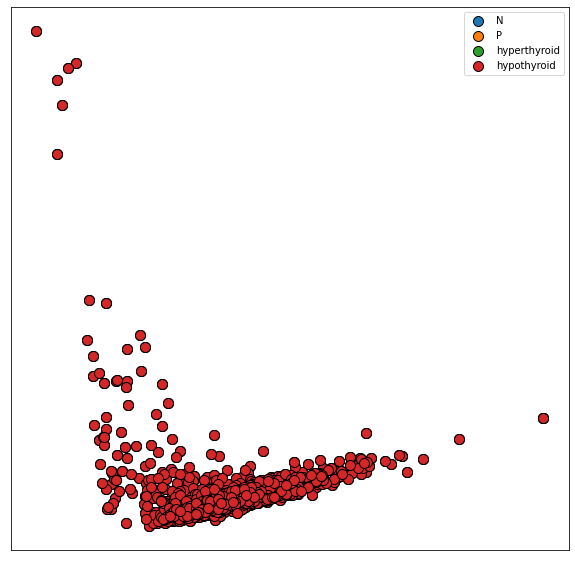

In [62]:
def plot_pca_data(X, y):    
    
    LE = LabelEncoder()
    y_encoded = LE.fit_transform(y)
    
    pca = PCA(n_components=2)
    pca.fit(X)
    pca_X = pca.transform(X)

    x_axis = pca_X[:,0]
    y_axis = pca_X[:,1]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    for label in np.unique(y):
        ax.scatter(pca_X[y==label, 0],
                   pca_X[y==label, 1], 
                   label=label,
                   s=100,
                   edgecolor='k')
        

    ax.legend()
    plt.xticks([])
    plt.yticks([])

plot_pca_data(X, y)

# Parameter of SVM Selection

In [65]:
def search_for_parameters(estimator, X_data, y_data, grid_parameters, scoring='accuracy', cv=3):
    
    classes = y_data.unique()
    
    # Execute Grid Search
    grid_clf = GridSearchCV(estimator=estimator, scoring=scoring,
                            param_grid=grid_parameters, cv=cv,n_jobs=-1)
    
    grid_clf.fit(X_data, y_data)

    print("The best parameters are: ", grid_clf.best_params_)

    return grid_clf.best_params_

In [68]:
svm_clf = SVC(class_weight='balanced')

svm_params_list = {'C':[8], 
                   'kernel':['poly'], 
                   'degree':[5], 
                   'gamma':['scale']}
"""
svm_params_list = {'C':[1,2,4,8], 
                   'kernel':['poly', 'rbf', 'sigmoid'], 
                   'degree':[3,4,5], 
                   'gamma':['auto','scale']}
"""
svm_parameters = search_for_parameters(estimator=svm_clf, 
                                X_data=X_train, 
                                y_data=y_train, cv=5,
                                grid_parameters=svm_params_list)

print(svm_clf.set_params(**svm_parameters))

svm_clf.fit(X_train, y_train)

The best parameters are:  {'C': 8, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}
SVC(C=8, class_weight='balanced', degree=5, kernel='poly')


SVC(C=8, class_weight='balanced', degree=5, kernel='poly')

# Evaluate Model

In [69]:
def cross_validate(estimator, X_data, y_data, scoring='accuracy', cv=3, Z=2):
    
    classes = y_data.unique()
    
    # Execute Cross Validation
    scores = cross_val_score(estimator=estimator, X=X_data, y=y_data, cv=cv, scoring=scoring)

    print("Model Scoring Evaluation Results")
    print("The mean score and the confidence interval of the score estimate are:")
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * Z))

cross_validate(estimator=svm_clf, X_data=X_train, y_data=y_train, cv=5)

Model Scoring Evaluation Results
The mean score and the confidence interval of the score estimate are:
Accuracy: 0.26 (+/- 0.01)


# Predict on Test Set

In [70]:
y_true, y_pred = y_test, svm_clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("*"*50)
print()
print("\t\t\tClassification Report")
print()
print(classification_report(y_true, y_pred))

Accuracy: 0.24533045977011494
**************************************************

			Classification Report

              precision    recall  f1-score   support

           N       0.19      0.79      0.30        73
           P       0.27      0.34      0.30       855
hyperthyroid       0.22      0.15      0.18       928
 hypothyroid       0.26      0.21      0.23       928

    accuracy                           0.25      2784
   macro avg       0.23      0.37      0.25      2784
weighted avg       0.25      0.25      0.24      2784



In [71]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
print(cm)

[[138 281   0 399 110]
 [222 193   0 409 104]
 [  0   0   0   0   0]
 [253 269   0 294  39]
 [  8   5   0   2  58]]
